# CEBRA feature selection

cebra is a method to use time information, to label behavior variables either 'near' or 'far', and use contrastive learning to train for an embedding.
the embedding will be a nice visualization of neural maniford, and provide the behavior variable mapping in neural (embedding) space.

here we want the embedding learning can focus on the label that makes sense, and ignore the labels that does not.
currently (as of mar 25 i have not yet fully read the cebra code) im not sure if the base cebra can do this. let try.

## outline
- simulation data
- run cebra
- check res

### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
# import
from matplotlib import pyplot as plt
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path

In [4]:

import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [5]:

from notification import notify

## Simulation data
here we will make some simualtion data to test our hypothesis that the base cebra can find the intrinsic label and ignores the correlated label.

neural data:
- r: represent the neural data. we need some more dim but we can just duplicate them or make them linearly dependent. 

labels:
- x1: represent the intrinsic label.
- x2: represent the correlated label.

In [6]:
# # real data as a template
# with open(f'{workdir}/test/neural/cebra/test', 'rb') as f:
#     (neural_data, continuous_label) = pickle.load(f)
# neural_data.shape, continuous_label.shape

In [7]:
# linear data. (discrete correlation)
r = torch.linspace(0, 1, 10000+1)
neural_data = torch.vstack([r, r, r]).T
r0 = r+torch.rand_like(r)*0.1
r1 = r+torch.rand_like(r)*0.1

x1 = r0+torch.rand_like(r)*0.1
x2 = r0+r1+torch.rand_like(r1)*0.1
continuous_label = torch.vstack([x1, x2]).T


neural_data.shape, continuous_label.shape

(torch.Size([10001, 3]), torch.Size([10001, 2]))

In [160]:
# gaussian data (continues correlation)
def gen_data_corr(original_data,corr = 0.5):
    return  original_data + torch.sqrt(torch.tensor(1 - corr**2)) * torch.randn(len(original_data), 1)


x = torch.randn(8888, 1)
x1=gen_data_corr(x, corr=0.9)
x2=gen_data_corr(x, corr=0.2)
r1,r2,r3=gen_data_corr(x1, corr=0.9),gen_data_corr(x1, corr=0.9),gen_data_corr(x1, corr=0.9)
continuous_label = torch.hstack([x1, x2])
neural_data = torch.hstack([r1, r2,r3])
neural_data.shape, continuous_label.shape

(torch.Size([8888, 3]), torch.Size([8888, 2]))

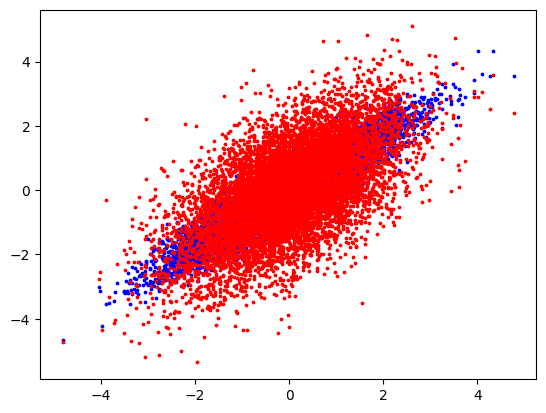

In [161]:
plt.scatter(neural_data[:,0],continuous_label[:,0] ,color='blue',s=3)
plt.scatter(neural_data[:,0],continuous_label[:,1] ,color='red',s=3)

# model and train

In [162]:
timesteps = neural_data.shape[0]
neurons = neural_data.shape[1]
out_dim = 2
max_iterations = 99
time_offsets = 10  # 0.1 s

single_cebra_model = CEBRA(model_architecture='offset10-model',
                           batch_size=None,  # whole dataset
                           learning_rate=0.01,
                           temperature_mode="auto",
                        #    temperature=1,
                           output_dimension=out_dim,
                           max_iterations=max_iterations,
                           distance='cosine',
                           conditional='time_delta',
                           device='cuda:0',
                           verbose=True,
                           time_offsets=time_offsets)



In [163]:
mymodel='my-model'

if mymodel not in cebra.models.get_options():
    from torch import nn
    import cebra.models
    import cebra.data
    from cebra.models.model import _OffsetModel, ConvolutionalModelMixin

    @cebra.models.register("my-model") # --> add that line to register the model!
    class MyModel(_OffsetModel, ConvolutionalModelMixin):

        def __init__(self, num_neurons, num_units, num_output, normalize=False):
            super().__init__(
                nn.Conv1d(num_neurons, num_units, 2),
                nn.GELU(),
                nn.Conv1d(num_units, num_units, 11),
                nn.GELU(),
                nn.Conv1d(num_units, num_output, 5),
                num_input=num_neurons,
                num_output=num_output,
                normalize=normalize,
            )

        def get_offset(self):
            return cebra.data.Offset(22, 23)

    # Access the model
print(cebra.models.get_options('my-model'))

single_cebra_model = CEBRA(model_architecture='my-model',
                           batch_size=None,  # whole dataset
                           learning_rate=0.03,
                           # temperature_mode="auto",
                           temperature=1,
                           output_dimension=out_dim,
                           max_iterations=max_iterations,
                           distance='cosine',
                           conditional='time_delta',
                           device='cuda:0',
                           verbose=True,
                           time_offsets=time_offsets)





['my-model']


In [164]:
#  training
for i in np.arange(5):
    single_cebra_model.fit(neural_data, continuous_label)
    # tmp_file = Path(f'{workdir}/test/neural/cebra/', f'cebra024612_0309fast_{i+1}hr.pt')
    # single_cebra_model.save(tmp_file)
    # notify(f'cebra {i} ready')

pos: -0.9896 neg:  10.0730 total:  9.0834 temperature:  1.0000:  39%|███▉      | 39/99 [00:00<00:00, 73.21it/s]

pos: -0.6741 neg:  9.6702 total:  8.9961 temperature:  1.0000: 100%|██████████| 99/99 [00:01<00:00, 66.89it/s] 
pos: -0.9978 neg:  10.0824 total:  9.0846 temperature:  1.0000: 100%|██████████| 99/99 [00:01<00:00, 59.79it/s]
pos: -0.6786 neg:  9.6759 total:  8.9973 temperature:  1.0000: 100%|██████████| 99/99 [00:01<00:00, 59.88it/s] 
pos: -0.9993 neg:  10.0840 total:  9.0847 temperature:  1.0000: 100%|██████████| 99/99 [00:01<00:00, 59.36it/s]
pos: -0.9969 neg:  10.0814 total:  9.0845 temperature:  1.0000: 100%|██████████| 99/99 [00:01<00:00, 60.31it/s]


Text(0.5, 1.0, 'training loss')

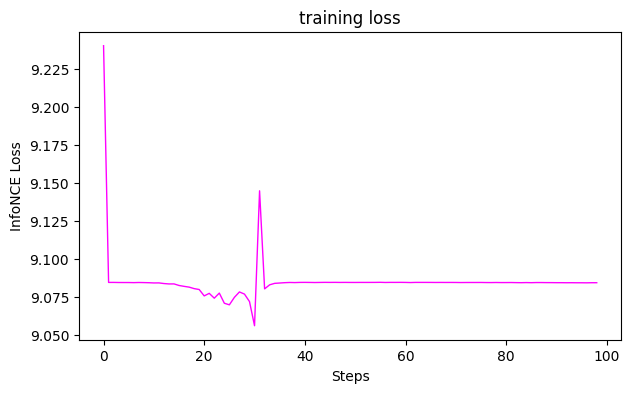

In [165]:
%matplotlib inline

ax=cebra.plot_loss(single_cebra_model)
ax.set_title('training loss')

# ax=cebra.plot_temperature(single_cebra_model)
# ax.set_title('temperature')


# Analysis

In [166]:
embedding = single_cebra_model.transform(neural_data)

### plot functions

In [167]:
from matplotlib import pyplot as plt

def plot_embedding_contrast(ax, embedding, label, gray = False, beh_idx=(0,1), idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx[0]]-label[:, beh_idx[1]]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1,2)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2, idx3 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               embedding [:,idx3],
               c=r_c,
               vmin=0,
               vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.zaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.set_zlabel('dim 3')
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.axis('equal')
    return ax

def plot_embedding2d(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2 = idx_order
    r=ax.scatter(embedding [:,idx1],
               embedding [:,idx2],
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax


def project_and_unfold(x, y):
    # Step 1: Calculate distance of each point from the origin
    distance = np.sqrt(x**2 + y**2)
    
    # Step 2: Find nearest point on the circle
    radius = 1
    x_projected = x / distance
    y_projected = y / distance
    
    # Step 3: Unfold the circle onto a line
    angle = np.arctan2(y_projected, -x_projected)
    
    x_unfolded = angle


    y_unfolded = distance - radius
    
    return x_unfolded, y_unfolded

def plot_embedding2d_unflold_line(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2 = idx_order
    x,y = embedding [:,idx1], embedding [:,idx2]
    x_unfolded, y_unfolded = project_and_unfold(x, y)

    r=ax.scatter(x_unfolded,
               y_unfolded,
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)
    plt.colorbar(r)
    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    return ax

def plot_embedding2d_unflold(ax, embedding, label, gray = False, beh_idx=0, idx_order = (0,1)):
    if not gray:
        r_cmap = 'cool'
        r_c = label[:, beh_idx]
    else:
        r_cmap = None
        r_c = 'gray'
    idx1, idx2 = idx_order
    x,y = embedding [:,idx1], embedding [:,idx2]
    x_unfolded, y_unfolded = project_and_unfold(x, y)

    r=ax.scatter(x_unfolded,
               r_c,
               c=r_c,
            #    vmin=0,
            #    vmax=1,
               cmap=r_cmap, s=0.5)

    ax.grid(False)
    ax.xaxis.set_ticks([-1,0,1])
    ax.yaxis.set_ticks([-1,0,1])
    ax.set_xlabel('dim 1')
    ax.set_ylabel('dim 2')
    ax.axis('equal')
    corr_coef = np.corrcoef(x_unfolded.squeeze(), r_c.squeeze())[0, 1].item()
    ax.set_title(f'corr = {corr_coef :.2f}')
    return ax




### 2d embedding

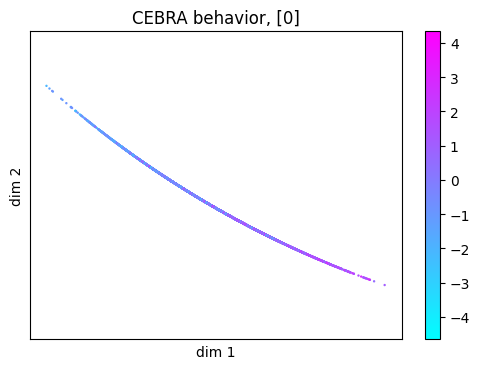

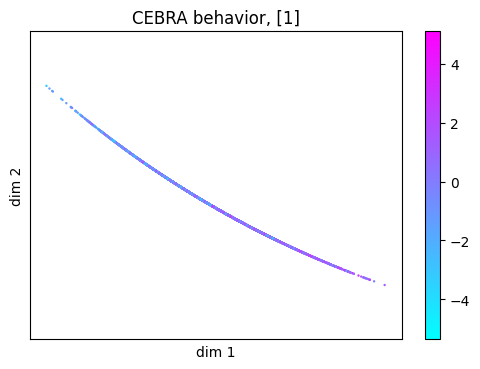

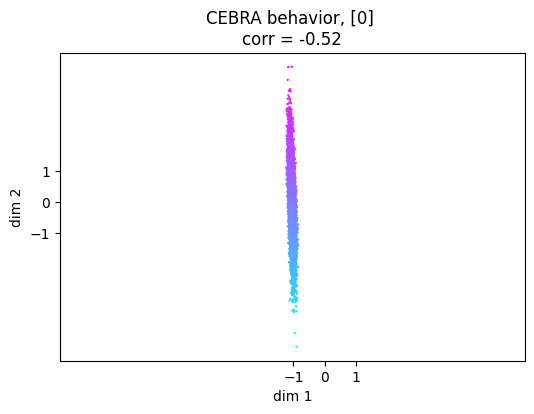

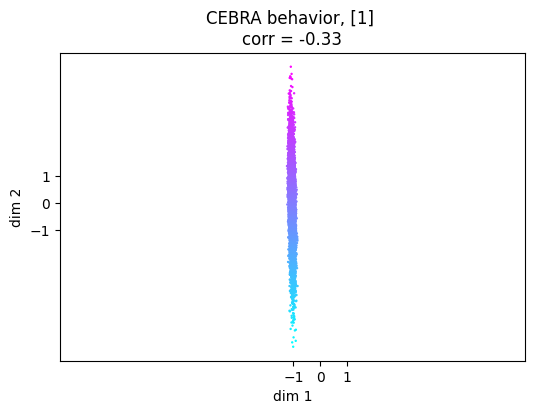

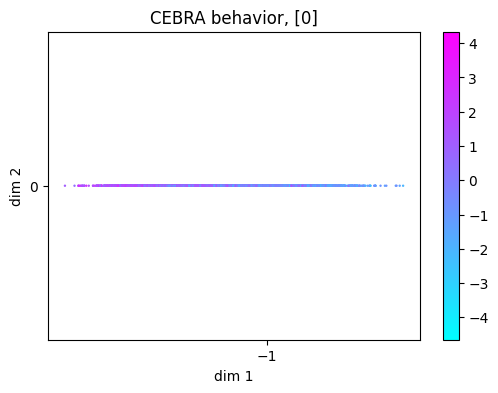

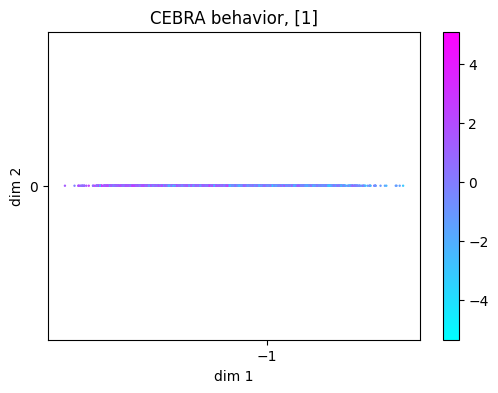

In [168]:
# %matplotlib inline

for beh_idx in range(continuous_label.shape[1]):

    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1 = plot_embedding2d(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior, {[beh_idx]}')
    plt.show()


for beh_idx in range(continuous_label.shape[1]):
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1 = plot_embedding2d_unflold(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior, {[beh_idx]} \n{ax1.get_title()}')
    plt.show()

for beh_idx in range(continuous_label.shape[1]):
    fig = plt.figure(figsize=(6,4))
    ax1 = plt.subplot(111)
    ax1 = plot_embedding2d_unflold_line(ax1, embedding, continuous_label, beh_idx=beh_idx)
    ax1.set_title(f'CEBRA behavior, {[beh_idx]}')
    plt.show()

we expect the two dim shows very similar embedding, because they are tightly correlated.

## check the model weights

singl